# Notes:
- Here I test SR -> Yolo -> ResNet

Train:
Kieu 1871
Kieu 1902

Test:
LVT

TODO:
- Finetune models with SR images... Seems like SR add feature that beyond model capability

# Import libraries

In [1]:
from NomDataset import NomDatasetV1, NomDatasetV2

# Standard libraries imports
import importlib
import os
import glob
import random
import shutil
from tqdm import tqdm
import pybboxes as pbx


# Data manipulation libraries imports (for image processing)
import pandas as pd
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pickle

# Torch libraries imports
import torch
from torch import nn
from torch.nn.functional import softmax
from torch.utils.data import DataLoader, Dataset
from torch.optim import Adam, SGD
from torch.optim.lr_scheduler import StepLR


# Pytorch Lightning libraries imports
import pytorch_lightning as pl
from pytorch_lightning import Trainer, seed_everything
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.loggers.csv_logs import CSVLogger
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping

# Torch utilities libraries imports
import torchmetrics
from torchsummary import summary
from torchmetrics.image import PeakSignalNoiseRatio, StructuralSimilarityIndexMeasure
from torchvision.models import resnet101
from torchvision import transforms

torch.cuda.empty_cache()
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Init Nom DataLoader

In [3]:
ToK1871_annotation = 'NomDataset/datasets/mono-domain-datasets/tale-of-kieu/1871/1871-annotation/annotation-mynom/'
ToK1871_image = 'NomDataset/datasets/mono-domain-datasets/tale-of-kieu/1871/1871-raw-images/'

ToK1902_annotation = 'NomDataset/datasets/mono-domain-datasets/tale-of-kieu/1902/1902-annotation/annotation-mynom/'
Tok1902_image = 'NomDataset/datasets/mono-domain-datasets/tale-of-kieu/1902/1902-raw-images/'

LVT_annotation = 'NomDataset/datasets/mono-domain-datasets/luc-van-tien/lvt-annotation/annotation-mynom/'
LVT_image = 'NomDataset/datasets/mono-domain-datasets/luc-van-tien/lvt-raw-images/'

ToK1871_Dataset = NomDatasetV2(root_annotation=ToK1871_annotation, root_image=ToK1871_image, scale=4, input_dim=(256, 256))
ToK1902_Dataset = NomDatasetV2(root_annotation=ToK1902_annotation, root_image=Tok1902_image, scale=4, input_dim=(256, 256))
LVT_Dataset = NomDatasetV2(root_annotation=LVT_annotation, root_image=LVT_image, scale=4, input_dim=(256, 256))

NomDataloader = DataLoader(ToK1871_Dataset, batch_size=1, shuffle=True, num_workers=0)

  0%|          | 0/137 [00:00<?, ?it/s]

100%|██████████| 105/105 [00:03<00:00, 26.72it/s]


A batch sample of NomDataset:
Image path:  ('NomDataset/datasets/mono-domain-datasets/tale-of-kieu/1871/1871-raw-images/tale-of-kieu-1871-page098.jpg',)
Char labels:  [[('參',)], [('商',)], [('拯',)], [('院',)], [('𫳘',)], [('從',)], [('在',)], [('埃',)], [('呵',)], [('敢',)], [('負',)], [('𢚸',)], [('故',)], [('人',)], [('錦',)], [('𤾓',)], [('卷',)], [('泊',)], [('𠦳',)], [('斤',)], [('謝',)], [('𢚸',)], [('易',)], [('称',)], [('報',)], [('恩',)], [('噲',)], [('𦉼',)], [('㛪',)], [('払',)], [('鬼',)], [('怪',)], [('精',)], [('魔',)], [('番',)], [('尼',)], [('几',)], [('𠎨',)], [('?',)], [('𫅷',)], [('﨤',)], [('𬖉',)], [('蜆',)], [('𨁏',)], [('𠰘',)], [('𡃹',)], [('渚',)], [('𥹰',)], [('謀',)], [('溇',)], [('拱',)], [('者',)], [('義',)], [('溇',)], [('朱',)], [('皮',)], [('束',)], [('生',)], [('𬖉',)], [('𩈘',)], [('閉',)], [('𣇞',)], [('蒲',)], [('灰',)], [('払',)], [('㐌',)], [('如',)], [('湄',)], [('𣿌',)], [('滛',)], [('𢚸',)], [('貞',)], [('𢜠',)], [('𢜝',)], [('坤',)], [('扲',)], [('𢜝',)], [('台',)], [('麻',)], [('吏',)], [('𢜠',)], [('忱',)], [('朱',)], [(

Text(0.5, 1.0, 'x4 bicubic LR image')

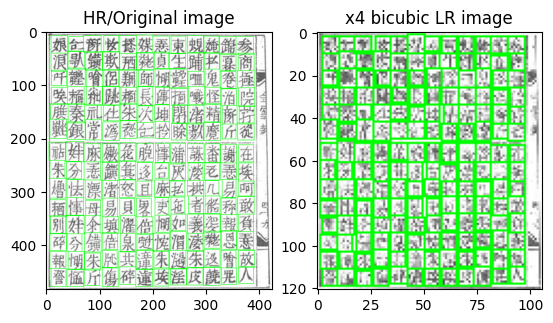

In [14]:
# This cell is meant to demonstrate the output of the NomDataLoader
print("A batch sample of NomDataset:")

for i, batch in enumerate(NomDataloader):
    img_path, img_hr, img_lr, coords_hr, coords_lr, labels_char, labels_unicode_cn, labels_unicode_vn = batch
    break   # To get first batch only
print("Image path: ", img_path)
print("Char labels: ", labels_char)
print("Unicode CN labels: ", labels_unicode_cn)
print("Unicode VN labels: ", labels_unicode_vn)

img_hr = img_hr.squeeze(0).numpy()
img_lr = img_lr.squeeze(0).numpy()


for coord_hr in coords_hr:
    x1, y1, x2, y2 = map(int, coord_hr)
    img_hr = cv2.rectangle(img_hr, (x1, y1), (x2, y2), (0, 255, 0), 1)
        
for coord_lr in coords_lr:
    x1, y1, x2, y2 = map(int, coord_lr)
    img_lr = cv2.rectangle(img_lr, (x1, y1), (x2, y2), (0, 255, 0), 1)    

plt.subplot(1, 2, 1)
plt.imshow(img_hr)
plt.title("HR/Original image")
plt.subplot(1, 2, 2)
plt.imshow(img_lr)
plt.title("x4 bicubic LR image")


# Run SR model on images

In [ ]:
from ESRGAN import RRDBNet_arch as ESRGAN_arch
# ESRGAN model is stuck at x4 scale
# NOTE: Recommended to save x4 image, because it's long to run
# TODO: Try to train ESRGAN model at x2 scale
# TODO: Try other SR model
# TODO: Try finetuning models

# Hardcoded paths
model_path = "ESRGAN/models/RRDB_ESRGAN_x4.pth"
test_img_folder = "ESRGAN/runs/inputs"
sr_img_folder = "ESRGAN/runs/outputs"

# nc = nChannels, nf = nFilters, nb = nBlocksOfRRDB, gc = growthChannels
# TODO: What is gc?
model = ESRGAN_arch.RRDBNet(in_nc=3, out_nc=3, nf=64, nb=23, gc=32)
model.load_state_dict(torch.load(model_path), strict=True)
model.eval()
model = model.to(DEVICE)

print('Model path {:s}. \nTesting...'.format(model_path))

psnr_list = []
ssim_list = []
psnr = PeakSignalNoiseRatio()
ssim = StructuralSimilarityIndexMeasure()

for i, batch in enumerate(NomDataloader):
    img_path, img_hr, img_lr, coords_hr, coords_lr, labels_char, labels_unicode_cn, labels_unicode_vn = batch
    img_name = os.path.basename(str(img_path[0])).strip(".jpg")
    
    img_lr = img_lr.float().permute(0, 3, 1, 2) * 1.0 / 255
    img_hr = img_hr.float().permute(0, 3, 1, 2) * 1.0 / 255
    
    img_lr = img_lr.to(DEVICE)
    img_hr = img_hr.to(DEVICE)
    
    with torch.no_grad():
        # img_sr = model(img_lr).data.squeeze().float().cpu().clamp_(0, 1).permute(1, 2, 0).numpy()
        img_sr = model(img_hr).data.squeeze().float().cpu().clamp_(0, 1).permute(1, 2, 0).numpy()
        img_sr = (img_sr * 255.0).round().astype(np.uint8)
    cv2.imwrite(os.path.join(sr_img_folder, "SR_" + str(img_name) + ".png"), img_sr)
    
    # psnr_val = psnr(img_sr, img_hr)
    # ssim_val = ssim(img_sr, img_hr)
    
    if i == 0:
        # Show first batch sample
        img_lr = img_lr * 255.0
        img_hr = img_hr * 255.0
        img_lr = img_lr.cpu().squeeze().permute(1, 2, 0).detach().numpy().astype(np.uint8)
        img_hr = img_hr.cpu().squeeze().permute(1, 2, 0).detach().numpy().astype(np.uint8)
        
        plt.subplot(1, 3, 1)
        plt.imshow(img_lr)
        plt.title("LR")
        plt.subplot(1, 3, 2)
        plt.imshow(img_hr)
        plt.title("HR")
        plt.subplot(1, 3, 3)
        plt.imshow(img_sr)
        plt.title("SR from HR")
    
    print(f"{i} {img_name}")
        # print(f"PSNR: {psnr_val.item():.3f} SSIM: {ssim_val.item():.3f}")
    
#     psnr_list.append(psnr_val)
#     ssim_list.append(ssim_val)
        
# psnr_list = torch.stack(psnr_list)
# ssim_list = torch.stack(ssim_list)
# print("Average PSNR: ", torch.mean(psnr_list))
# print("Average SSIM: ", torch.mean(ssim_list))

# Run Yolov5 on input images

In [ ]:
!python yolov5/detect.py --weights yolov5/weights/yolo_one_label.pt --imgsz 640 --conf 0.25 --source ESRGAN/runs/outputs --nosave --save-txt

In [ ]:
# yolo_model = torch.hub.load('ultralytics/yolov5', 'custom', path='yolov5/weights/yolo_one_label.pt', verbose=False)
# sr_image_path = "ESRGAN/runs/outputs"
# yolo_model.conf = 0.25

# img_path = os.path.join(sr_image_path, os.listdir(sr_image_path)[0])
# img = cv2.imread(img_path)
# results = yolo_model(img_path, size=640)
# for index, row in results.pandas().xyxy[0].iterrows():
#     x1, y1, x2, y2 = map(int, row[0:4])
#     img = cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 1)



# Resnet101

In [15]:
class PytorchResNet101(pl.LightningModule):
    def __init__(self, num_labels):
        super(PytorchResNet101, self).__init__()
        self.save_hyperparameters()
        self.num_labels = num_labels

        # get ResNet architecture
        backbone = resnet101(pretrained=True)
        num_filters = backbone.fc.in_features
        layers = list(backbone.children())[:-1]
        self.feature_extractor = nn.Sequential(*layers)

        self.classifier = nn.Linear(num_filters, self.num_labels)

        self.criterion = nn.CrossEntropyLoss(reduction = 'mean')
        self.metrics_accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=self.num_labels)

        self.training_step_outputs = []
        self.validation_step_outputs = []
        self.test_step_outputs = []


    def forward(self, x):
        representations = self.feature_extractor(x).flatten(1)
        classification = self.classifier(representations)

        return classification


    def configure_optimizers(self):
        optimizer = SGD(self.parameters(), lr=0.00001, weight_decay=1e-4, momentum=0.9)
        # optimizer = Adam(self.parameters(), lr=0.001, eps=1)
        scheduler = StepLR(optimizer, step_size=20, gamma=0.0005)
        # return dict(
        #     optimizer=optimizer,
        #     lr_scheduler=dict(
        #         scheduler=scheduler,
        #         interval='step'
        #     )
        # )
        return optimizer


    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)

        # accuracy
        y_hat_softmax = softmax(y_hat)
        y_hat_argmax = torch.argmax(y_hat_softmax, dim=1)

        acc = self.metrics_accuracy(y_hat_argmax, y)
        self.log('train_accuracy', acc, on_step=True, on_epoch=True, prog_bar=True, logger=True)

        # loss
        loss = self.criterion(y_hat, y)
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)

        self.training_step_outputs.append(loss)

        return {'loss': loss, 'train_accuracy': acc}


    def on_train_epoch_end(self):
        epoch_average = torch.stack(self.training_step_outputs).mean()

        self.log('train_acc_epoch', epoch_average, on_epoch=True, prog_bar=True, logger=True)
        self.training_step_outputs.clear()


    # def convert_to_one_hot(self, y):
    #     vector = np.zeros((y.shape[0], self.num_labels))
    #     vector = torch.eye(self.num_labels)[y]
    #     return torch.tensor(vector, dtype=torch.int)

    # VALIDATION
    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)

        # accuracy
        y_hat_softmax = softmax(y_hat)
        y_hat_argmax = torch.argmax(y_hat_softmax, dim=1)

        acc = self.metrics_accuracy(y_hat_argmax, y)
        self.log('val_acc', acc, on_step=True, on_epoch=True, prog_bar=True, logger=True)

        # loss
        loss = self.criterion(y_hat, y)
        self.log('val_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)

        self.validation_step_outputs.append(loss)

        return {'val_loss': loss, 'val_accuracy': acc}

    def validation_step_end(self, batch_parts):
        return batch_parts

    def on_validation_epoch_end(self):
        epoch_average = torch.stack(self.validation_step_outputs).mean()

        self.log('val_acc_epoch', epoch_average, on_epoch=True, prog_bar=True, logger=True)
        self.validation_step_outputs.clear()


    # Saver
    def save_metrics(self, folder, filename, content):
        with open(folder  + filename + '.txt', 'w', encoding='utf-8') as the_txt_file:
            the_txt_file.write(str(content))
        with open(folder + filename + '.pickle', 'wb') as f:
            pickle.dump(content, f)


    # TEST
    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)

        y_hat_softmax = softmax(y_hat)
        y_hat_argmax = torch.argmax(y_hat_softmax, dim=1)

        # accuracy
        acc = self.metrics_accuracy(y_hat_argmax, y)
        self.log('test_accuracy', acc, on_step=True, on_epoch=True, prog_bar=True, logger=True)

        # loss
        loss = self.criterion(y_hat, y)
        self.log('test_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)

        self.test_step_outputs.append(loss, acc)

        # return {'test_loss': loss, 'test_accuracy': acc, 'ap': ap, 'auroc': auroc, 'confusion_matrix':confmat, 'f1': f1}
        return {'test_loss': loss, 'test_accuracy': acc, 'y': y, 'y_hat':y_hat}

    def test_step_end(self, batch_parts):
        return batch_parts

    def on_test_epoch_end(self, test_step_outputs):
        acc = 0
        loss = 0
        count = 0
        y = None
        y_hat = None
        for test_step_out in test_step_outputs:
            if count == 0:
                y = test_step_out['y']
                y_hat = test_step_out['y_hat']
            else:
                y = torch.cat([y, test_step_out['y']], 0)
                y_hat = torch.cat([y_hat, test_step_out['y_hat']], 0)
            loss += test_step_out['test_loss']
            acc += test_step_out['test_accuracy']
            count += 1

        acc = acc / count
        self.log('test_acc_epoch', acc, on_epoch=True, prog_bar=True, logger=True)
        self.save_metrics('metrics/', 'test_acc_epoch', acc)

        loss = loss / count
        self.log('test_loss_epoch', loss, on_epoch=True, prog_bar=True, logger=True)
        self.save_metrics('metrics/', 'test_loss_epoch', loss)

        y_hat_softmax = softmax(y_hat)
        y_hat_argmax = torch.argmax(y_hat_softmax, dim=1)
        self.save_metrics('ys/', 'y', y)
        self.save_metrics('ys/', 'y_hat', y_hat)
        self.save_metrics('ys/', 'y_hat_softmax', y_hat_softmax)
        self.save_metrics('ys/', 'y_hat_argmax', y_hat_argmax)


# Run ResNet on box from Yolov5

In [4]:
# This dictionary is used to map unicode with character
han_nom_dict = {}
for i in tqdm(range(len(ToK1871_Dataset))):
    _, _, _, _, _, char, unicode_cn, _ = ToK1871_Dataset[i]
    assert len(char) == len(unicode_cn), "Length of character and unicode_cn must be the same"
    for character, cn_code in zip(char, unicode_cn):
        assert len(character) == 1
        assert len(cn_code) == 1
        
        character = character[0]
        cn_code = cn_code[0]
                
        if cn_code not in han_nom_dict:
            han_nom_dict[cn_code] = character
        
for i in tqdm(range(len(ToK1902_Dataset))):
    _, _, _, _, _, char, unicode_cn, _ = ToK1902_Dataset[i]
    assert len(char) == len(unicode_cn), "Length of character and unicode_cn must be the same"
    for character, cn_code in zip(char, unicode_cn):
        assert len(character) == 1
        assert len(cn_code) == 1
        
        character = character[0]
        cn_code = cn_code[0]
                
        if cn_code not in han_nom_dict:
            han_nom_dict[cn_code] = character
            
for i in tqdm(range(len(LVT_Dataset))):
    _, _, _, _, _, char, unicode_cn, _ = LVT_Dataset[i]
    assert len(char) == len(unicode_cn), "Length of character and unicode_cn must be the same"
    for character, cn_code in zip(char, unicode_cn):
        assert len(character) == 1
        assert len(cn_code) == 1
        
        character = character[0]
        cn_code = cn_code[0]
                
        if cn_code not in han_nom_dict:
            han_nom_dict[cn_code] = character        


print("Number of unique characters: ", len(han_nom_dict))
print("Sample of han_nom_dict: ", list(han_nom_dict.items()))
print("Test sample: ", han_nom_dict["59AF"])

100%|██████████| 105/105 [00:01<00:00, 78.27it/s]

Number of unique characters:  4049
Sample of han_nom_dict:  [('55E3', '嗣'), ('5FB7', '德'), ('4E8C', '二'), ('5341', '十'), ('56DB', '四'), ('5E74', '年'), ('4EF2', '仲'), ('6625', '春'), ('65B0', '新'), ('520B', '刋'), ('203A3', '𠎣'), ('7530', '田'), ('79AE', '禮'), ('53C3', '參'), ('962E', '阮'), ('4FAF', '侯'), ('64B0', '撰'), ('91D1', '金'), ('96F2', '雲'), ('7FF9', '翹'), ('50B3', '傳'), ('67F3', '柳'), ('6587', '文'), ('5802', '堂'), ('8535', '蔵'), ('677F', '板'), ('24F93', '𤾓'), ('221A5', '𢆥'), ('25A9E', '𥪞'), ('2139D', '𡎝'), ('2029B', '𠊛'), ('4E9B', '些'), ('21A38', '𡨸'), ('624D', '才'), ('547D', '命'), ('7A96', '窖'), ('2627C', '𦉼'), ('6044', '恄'), ('9952', '饒'), ('23971', '𣥱'), ('6208', '戈'), ('6CA1', '没'), ('5C40', '局'), ('23DED', '𣷭'), ('6A77', '橷'), ('4ECD', '仍'), ('8ABF', '調'), ('2C589', '𬖉'), ('2784A', '𧡊'), ('340C', '㐌'), ('24D2C', '𤴬'), ('75B8', '疸'), ('226B8', '𢚸'), ('2850D', '𨔍'), ('4E4B', '之'), ('5F7C', '彼'), ('55C7', '嗇'), ('65AF', '斯'), ('8C50', '豐'), ('215F6', '𡗶'), ('6491', '撑'), ('6D93',

In [17]:
data_path_label = 'NomDataset/HWDB1.1-bitmap64-ucode-hannom-v2-tst_seen-label-set-ucode.pkl'
with open(data_path_label, 'rb') as f:
    unicode_labels = pickle.load(f)
    unicode_labels = sorted(list(unicode_labels.keys()))
print("Total number of unicode: ", len(unicode_labels))
print(unicode_labels)

Total number of unicode:  5568
['100014', '100015', '100017', '100025', '100030', '100032', '100048', '100051', '100058', '100072', '100074', '100075', '100079', '100084', '100089', '100090', '100095', '100102', '100136', '100142', '100154', '100186', '100203', '100213', '100216', '100223', '100260', '100263', '100264', '100268', '100270', '100272', '100276', '100284', '100287', '100302', '100304', '100305', '100308', '100310', '100322', '100325', '100338', '100342', '100344', '100352', '100353', '100357', '100362', '100383', '100391', '100409', '100412', '100415', '100429', '100435', '100463', '100464', '100465', '100479', '100481', '100488', '100490', '100505', '100506', '100510', '100511', '100514', '100515', '100518', '100519', '100540', '100543', '100571', '100574', '100577', '100581', '100582', '100584', '100592', '100593', '100594', '100599', '100600', '100601', '100603', '100609', '100611', '20027', '20032', '20040', '20051', '20054', '2005F', '200C5', '200E3', '200E9', '20129'

In [18]:
weights_path = 'PytorchResNet101Pretrained-data-v2-epoch=14-val_loss_epoch=1.42927-train_acc_epoch=0.99997-val_acc_epoch=0.79039.ckpt'
model = PytorchResNet101.load_from_checkpoint(weights_path, num_labels=len(unicode_labels))
model.eval()
model.freeze()
model.to(DEVICE)

c:\Users\Soppo\Documents\GitHub\Thesis\.venv\lib\site-packages\pytorch_lightning\utilities\migration\migration.py:207: You have multiple `ModelCheckpoint` callback states in this checkpoint, but we found state keys that would end up colliding with each other after an upgrade, which means we can't differentiate which of your checkpoint callbacks needs which states. At least one of your `ModelCheckpoint` callbacks will not be able to reload the state.
Lightning automatically upgraded your loaded checkpoint from v1.3.4 to v2.1.3. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint c:\Users\Soppo\Documents\GitHub\Thesis\PytorchResNet101Pretrained-data-v2-epoch=14-val_loss_epoch=1.42927-train_acc_epoch=0.99997-val_acc_epoch=0.79039.ckpt`
c:\Users\Soppo\Documents\GitHub\Thesis\.venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, ple

PytorchResNet101(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
       

In [19]:
def check_bb_intersection(bb1, bb2):
    x1, y1, x2, y2 = bb1
    x3, y3, x4, y4 = bb2
    
    if x3 > x2 or x4 < x1 or y3 > y2 or y4 < y1:
        return False
    else:
        return True

def calculate_iou(bb1, bb2):
    x1, y1, x2, y2 = bb1
    x3, y3, x4, y4 = bb2
    
    # Calculate the coordinates of the intersection rectangle
    x_left = max(x1, x3)
    y_top = max(y1, y3)
    x_right = min(x2, x4)
    y_bottom = min(y2, y4)
    
    # Calculate the area of intersection rectangle
    intersection_area = max(0, x_right - x_left + 1) * max(0, y_bottom - y_top + 1)
    
    # Calculate the area of both bounding boxes
    bb1_area = (x2 - x1 + 1) * (y2 - y1 + 1)
    bb2_area = (x4 - x3 + 1) * (y4 - y3 + 1)
    
    # Calculate the IoU
    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    
    return iou

def find_best_iou(bb: list, bb_list: list):
    best_iou = 0
    best_iou_index = -1
    
    for i, bb2 in enumerate(bb_list):
        iou = calculate_iou(bb, bb2)
        if iou > best_iou:
            best_iou = iou
            best_iou_index = i
    
    return best_iou, best_iou_index

Reading file:  SR_tale-of-kieu-1871-page054.png yolov5/runs/detect/exp2/labels\SR_tale-of-kieu-1871-page054.txt
950 1148 1190 1277
Char label:  [('詩',)]
Unicode label:  [('8A69',)]


C:\Users\Soppo\AppData\Local\Temp\ipykernel_13100\4122767833.py:51: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred = softmax(pred)


Results:  426
Predicted char - Ucode dict:  241E5
Predicted char - Han Nom dict:  ('5E92', '庒')


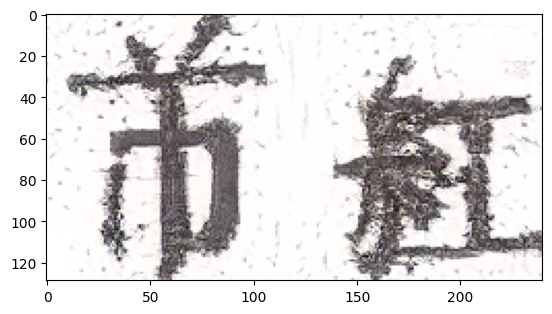

In [22]:
yolo_crop_path = "yolov5/runs/detect/exp2/labels"
sr_image_path = "TempResources/SR_from_HR"

for i, batch in enumerate(NomDataloader):
    img_path, img_hr, img_lr, coords_hr, coords_lr, labels_char, labels_unicode_cn, labels_unicode_vn = batch
    img_name = os.path.basename(str(img_path[0])).strip(".jpg")
    
    img_sr_name = "SR_" + str(img_name) + ".png"
    img_sr_path = os.path.join(sr_image_path, img_sr_name)
    
    img_sr = cv2.imread(img_sr_path)
    h, w, _ = img_sr.shape
    
    # TODO: Make SCALE global variable
    SCALE = 4
    coords_sr = coords_hr * SCALE
    
    bb_file_path = os.path.join(yolo_crop_path, "SR_" + str(img_name) + ".txt")
    
    print("Reading file: ", img_sr_name,  bb_file_path)
    
    with open(bb_file_path, 'r') as f:
        bb_list = f.readlines()
        for i, bb in enumerate(bb_list):
            bb_list[i] = bb.split(" ")
            _, x_center, y_center, bb_width, bb_height = map(float, bb_list[i])
            
            x1, y1, x2, y2 = pbx.convert_bbox((x_center, y_center, bb_width, bb_height), from_type='yolo', to_type='voc', image_size=(w, h))
            print(x1, y1, x2, y2)
            
            # cv2.rectangle(img_sr, (x1, y1), (x2, y2), (0, 255, 0), 3)
            
            # Get ground truth label using the best IoU
            _, idx = find_best_iou([x1, y1, x2, y2], coords_sr)
            char_label = labels_char[idx]
            unicode_label = labels_unicode_cn[idx]
            print("Char label: ", char_label)
            print("Unicode label: ", unicode_label)
            
            # Cropped up for ResNet101 to classify
            crop_img = img_sr[y1:y2, x1:x2]
            plt.imshow(crop_img)
            
            # Resize to 256x256, sth about img input size for resnet. Then do the normalize stuffs
            crop_img = cv2.resize(crop_img, (256, 256))
            crop_img = crop_img / 255.0
            crop_img = torch.tensor(crop_img).permute(2, 0, 1).unsqueeze(0).float()
            crop_img = crop_img.to(DEVICE)
            
            pred = model(crop_img)
            pred = softmax(pred)
            pred = torch.argmax(pred, dim=1)
            pred = pred.item()
            
            
            print("Results: ", pred)
            
            ucode = unicode_labels[pred]
            
            
            ucode_2 = list(han_nom_dict.items())[pred]
            print("Predicted char - Ucode dict: ", ucode)
            print("Predicted char - Han Nom dict: ", ucode_2)
            break
            
    # plt.imshow(img_sr)
    break
